# Model Creation and Evaluation

In this section multiple models will be created and evaluated before a final model is chosen and evaluated.

## Import Libraries

As always, we start by importing the required libraries

In [14]:
# Import Pandas
import pandas as pd

# Import Numpy
import numpy as np

# All the SciKit Learn Libraries Required
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

# Decision Tree
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier

# Small Function to do X-Fold Cross Validation
def cross_validate(model, n_splits = 10):
    
    k_fold = KFold(n_splits = n_splits)
    scores = [model.fit(X[train], y[train]).score(X[test], y[test]) for train, test in k_fold.split(X)]
    
    scores = np.percentile(scores, [40, 50, 60])
    return scores

In [3]:
# Use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

font = {'size'   : 12}
mpl.rc('font', **font)

## Import Dataframes from Pickle files

We load in the exported pickle files of the dataframes created in the Data Acquition Section.

In [5]:
# Import the Pickle of the Crimes DataFrame
df_crimes = pd.read_pickle('./capstone_pickles/crimes.pkl')
df_crimes.drop('index', inplace=True, axis=1)

# Import the Pickle of the Top Venues DataFrame
df_topvnues = pd.read_pickle('./capstone_pickles/top_venues.pkl')

# Import the Pickle of the Restaurants DataFrame
df_rest = pd.read_pickle('./capstone_pickles/restaurants.pkl')

# Data Preparation for Modelling

Before we start modelling we need to prepare the data frame to include only mumerical data and by removing unneeded columns.

Rather than removing colums from `df_crimes` a new `df_features` DataFrame will be created with just the required columns. This `df_features` DataFrame will then be processed to remove Categorical Data Types and replace them with One Hot encoding. Finally the Dependant Variables will be Normalised.

In [6]:
# Start by copying the Latitude and Longitude to the new DataFrame
df_features = df_crimes[['latitude', 'longitude']]

# Next and One Hot Encoding of the hour, day and month variables
df_features = df_features.join(pd.get_dummies(df_crimes.hour, prefix='hour'))
df_features = df_features.join(pd.get_dummies(df_crimes.day_name))
df_features = df_features.join(pd.get_dummies(df_crimes.month_name))

# Finally add the ward & crimes column, copied from the original Primary Description column
df_features['ward'] = df_crimes[['ward']]
df_features['crimes'] = df_crimes[['primary_description']]

In [7]:
df_features.head()

,latitude,longitude,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,January,July,June,March,May,November,October,September,ward,crimes
0,41.897895,-87.760744,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,37.0,NARCOTICS
1,41.798635,-87.604823,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,CRIMINAL DAMAGE
2,41.780946,-87.621995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20.0,THEFT
3,41.965404,-87.736202,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,39.0,THEFT
4,41.850673,-87.735597,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22.0,ARSON


There are a couple of further small changes to be made:
 - Create a smaller DataFrame of only the top two crimes
 - Create the X, dependant variables, DataFrames by dropping the Crimes column
 - Create the y, independant variable, 
 - Normailse the X Data

In [116]:
# Create a list of the 2 most commonly occuring crimes
top_two_crimes = df_features[['crimes', 'ward']].groupby(
    ['crimes']).count().sort_values('ward', ascending=False)[:2].axes[0].tolist()

# Create a smaller DataFrame of only the top two crimes
df_features_2 = df_features[df_features['crimes'].isin(top_two_crimes)].copy()

In [117]:
X_2 = df_features_2.copy()
y_2 = X_2.crimes.values

X_2.drop('crimes', axis=1, inplace=True)
X_2 = preprocessing.StandardScaler().fit(X_2).transform(X_2)

In [118]:
# Set X = X_2
X = X_2
y = y_2

### K Nearest Neighbor(KNN)
Find the best k to build the model with the best accuracy.

Heighbours:  8   2018-10-08 15:52:13.421456
Heighbours:  9   2018-10-08 16:00:51.217053
Heighbours:  10   2018-10-08 16:10:11.199822
Heighbours:  11   2018-10-08 16:21:14.573951
Heighbours:  12   2018-10-08 16:31:42.417515


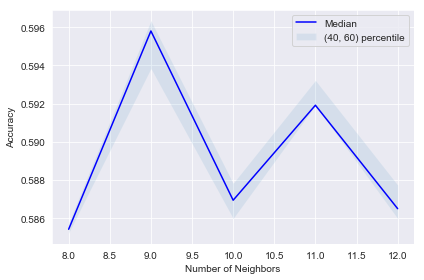

In [26]:
# Number of neighbours
neighs = range(8, 13)

# Store the scores
scores = np.zeros((len(neighs), 3))

# Iterate to find the best model
for idx, neigh in enumerate(neighs):
    print('Heighbours: ', neigh, ' ', str(datetime.now()))
    model = KNeighborsClassifier(n_neighbors = neigh)
    scores[idx, : ] = cross_validate(model, n_splits = 10)

# Plot the results
plt.plot(neighs, scores[ : , 1], 'b')
plt.fill_between(neighs, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

K = 9 give the best results

In [27]:
KNN_model = KNeighborsClassifier(n_neighbors = 9).fit(X, y)

## Decision Tree

Depth:  12   2018-10-08 15:02:12.477505
Depth:  13   2018-10-08 15:02:22.472386
Depth:  14   2018-10-08 15:02:33.055559
Depth:  15   2018-10-08 15:02:44.095253
Depth:  16   2018-10-08 15:02:55.639814
Depth:  17   2018-10-08 15:03:07.639090


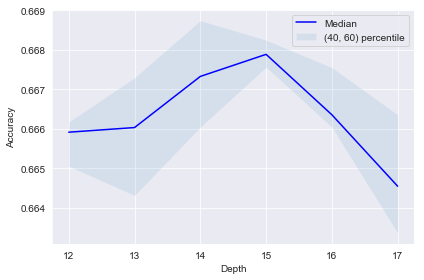

In [20]:
# Decision Tree
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier

# Depth of the Secision Trees
depths = range(12, 18)

# Store the scores
scores = np.zeros((len(depths), 3))

# Iterate to find the best model
for idx, depth in enumerate(depths):
    print('Depth: ', depth, ' ', str(datetime.now()))
    model = DecisionTreeClassifier(criterion = "entropy", max_depth = depth)
    scores[idx, : ] = cross_validate(model, n_splits = 10)

# Plot the results
plt.plot(depths, scores[ : , 1], 'b')
plt.fill_between(depths, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.tight_layout()
plt.show()

Depth = 15 gives the best results

In [28]:
Tree_model = DecisionTreeClassifier(criterion = "entropy", max_depth = 15).fit(X, y)

## Logistic Regression

C:  0.01   2018-10-08 15:03:59.670515
C:  0.03162277660168379   2018-10-08 15:04:06.381485
C:  0.1   2018-10-08 15:04:13.146042
C:  0.31622776601683794   2018-10-08 15:04:19.914529
C:  1.0   2018-10-08 15:04:26.714254
C:  3.1622776601683795   2018-10-08 15:04:33.369058


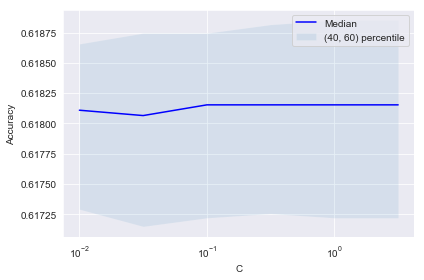

In [21]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

C = np.logspace(-2.0, 0.5, num = 6, endpoint = True)

scores = np.zeros((len(C), 3))

for idx, c in enumerate(C):
    print('C: ', c, ' ', str(datetime.now()))
    model = LogisticRegression(C = c, solver = 'liblinear')
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(C, scores[ : , 1], 'b')
plt.xscale('log')
plt.fill_between(C, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.tight_layout()
plt.show()

In [33]:
LR_model = LogisticRegression(C = 0.1, solver = 'liblinear').fit(X, y)

## Naive Bayes

Alpha:  0.1   2018-10-09 15:09:00.155736
Alpha:  0.2   2018-10-09 15:09:04.409987
Alpha:  0.30000000000000004   2018-10-09 15:09:08.654031
Alpha:  0.4   2018-10-09 15:09:12.821563
Alpha:  0.5   2018-10-09 15:09:16.959580
Alpha:  0.6   2018-10-09 15:09:21.133269
Alpha:  0.7000000000000001   2018-10-09 15:09:25.282914
Alpha:  0.8   2018-10-09 15:09:29.559000
Alpha:  0.9   2018-10-09 15:09:33.929067
Alpha:  1.0   2018-10-09 15:09:38.198636


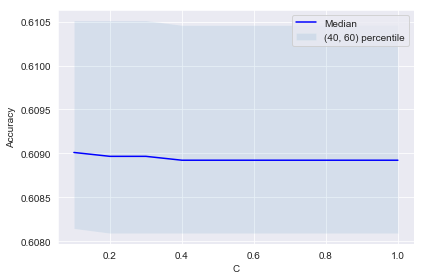

In [30]:
# Naive Bayes

alpha = np.linspace(0.1, 1, num=10)

scores = np.zeros((len(alpha), 3))

for idx, a in enumerate(alpha):
    print('Alpha: ', a, ' ', str(datetime.now()))
    model = BernoulliNB(alpha=a)
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(alpha, scores[ : , 1], 'b')
plt.fill_between(alpha, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.tight_layout()
plt.show()

In [32]:
NB_model = BernoulliNB(alpha=a).fit(X, y)

## Decision Forest using a Random Forest

Estimator:  20   2018-10-08 15:46:03.008463
Estimator:  21   2018-10-08 15:46:39.961439
Estimator:  22   2018-10-08 15:47:19.027772
Estimator:  23   2018-10-08 15:47:59.712219


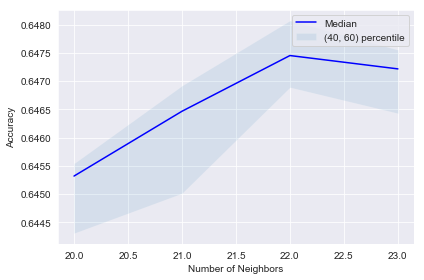

In [25]:


est = range(20, 24)
scores = np.zeros((len(est), 3))
for idx, a in enumerate(est):
    print('Estimator: ', a, ' ', str(datetime.now()))
    model = RandomForestClassifier(n_estimators = a, max_features = 'sqrt')
    scores[idx, : ] = cross_validate(model, n_splits = 10)

plt.plot(est, scores[ : , 1], 'b')
plt.fill_between(est, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [34]:
Forest_model = RandomForestClassifier(n_estimators = 22, max_features = 'sqrt').fit(X, y)

## Determine the best Model

In [35]:
# Function to iterate over each of the models to get their scores
def get_scores(model):

    # predict
    yhat = model.predict(X)
    
    jaccard = metrics.jaccard_similarity_score(y, yhat)
    f1 = metrics.f1_score(y, yhat, pos_label = 'THEFT')
    logloss = metrics.log_loss(y == 'THEFT', yhat == 'THEFT')
        
    return {'Jaccard' : jaccard, 'F1-Score' : f1, 'LogLoss' : logloss}

# Empty Results List    
results = []

# The Models
models = [[KNN_model, 'KNN'], 
          [Tree_model, 'Decision Tree'], 
          [NB_model, 'Bernoulli Naive Bayes'], 
          [LR_model, 'Logistic Regression'],
          [Forest_model, 'Random Forest']]

# Iterate over each of the models
for model, algorithm in models:
    
    scores = get_scores(model)
    scores['Algorithm'] = algorithm
    results.append(scores)

# Format the results and display them.
results = pd.DataFrame(results)
results.set_index('Algorithm', inplace = True)

results

,F1-Score,Jaccard,LogLoss
Algorithm,,,
KNN,0.735110,0.700167,10.355988
Decision Tree,0.739844,0.722507,9.584343
Bernoulli Naive Bayes,0.670262,0.610028,13.469334
Logistic Regression,0.692493,0.618332,13.182555
Random Forest,0.996330,0.995866,0.142790


In [36]:
results.to_pickle('./capstone_pickles/results.pkl')

# Best Model

Ramdom Forest is the best model scoring highest in all measurements, F1-Score, Jaccard and Log Loss. Let's now create a new model. The September crime data will become the unseen test data for the final model.

In [5]:
# Import the Pickle of the Crimes DataFrame
df_crimes = pd.read_pickle('./capstone_pickles/crimes.pkl')
df_crimes.drop('index', inplace=True, axis=1)

### Recreate the Features DataFrame

Recreate the Features DataFrame but this time use all of the data.

In [6]:
# Start by copying the Latitude and Longitude to the new DataFrame
df_features = df_crimes[['latitude', 'longitude']]

# Next and One Hot Encoding of the hour, day and month variables
df_features = df_features.join(pd.get_dummies(df_crimes.hour, prefix='hour'))
df_features = df_features.join(pd.get_dummies(df_crimes.day_name))
df_features = df_features.join(pd.get_dummies(df_crimes.month_name))

# Finally add the ward & crimes column, copied from the original Primary Description column
df_features['ward'] = df_crimes[['ward']]
df_features['crimes'] = df_crimes[['primary_description']]

# Create a list of the 2 most commonly occuring crimes
top_two_crimes = df_features[['crimes', 'ward']].groupby(
    ['crimes']).count().sort_values('ward', ascending=False)[:2].axes[0].tolist()

# Create a smaller DataFrame of only the top two crimes
df_features = df_features[df_features['crimes'].isin(top_two_crimes)].copy()

In [7]:
# Looking at the head of the features dataframe we can see the encoded labels
df_features.head()

,latitude,longitude,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,January,July,June,March,May,November,October,September,ward,crimes
2,41.780946,-87.621995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20.0,THEFT
3,41.965404,-87.736202,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,39.0,THEFT
7,41.895946,-87.629760,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,42.0,BATTERY
9,41.867081,-87.619004,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,THEFT
11,41.769917,-87.663955,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17.0,THEFT


In [8]:
df_features.dtypes

latitude     float64
longitude    float64
hour_0         uint8
hour_1         uint8
hour_2         uint8
hour_3         uint8
hour_4         uint8
hour_5         uint8
hour_6         uint8
hour_7         uint8
hour_8         uint8
hour_9         uint8
hour_10        uint8
hour_11        uint8
hour_12        uint8
hour_13        uint8
hour_14        uint8
hour_15        uint8
hour_16        uint8
hour_17        uint8
hour_18        uint8
hour_19        uint8
hour_20        uint8
hour_21        uint8
hour_22        uint8
hour_23        uint8
Friday         uint8
Monday         uint8
Saturday       uint8
Sunday         uint8
Thursday       uint8
Tuesday        uint8
Wednesday      uint8
April          uint8
August         uint8
December       uint8
February       uint8
January        uint8
July           uint8
June           uint8
March          uint8
May            uint8
November       uint8
October        uint8
September      uint8
ward         float64
crimes        object
dtype: object

### Create the Test Datasets

In [9]:
X_Train = df_features[df_features.September == 0].copy()
X_Train.drop('crimes', axis=1, inplace=True)

# Normalise df_features
X_Train = preprocessing.StandardScaler().fit(X_Train).transform(X_Train)

y_Train = df_features.crimes[df_features.September == 0].values

### Create the Train Datasets

In [10]:
X_Test = df_features[df_features.September == 1].copy()
X_Test.drop('crimes', axis=1, inplace=True)

# Normalise df_features
X_Test = preprocessing.StandardScaler().fit(X_Test).transform(X_Test)

y_Test = df_features.crimes[df_features.September == 1].values

### Recreate the Random Forest Model

In [11]:
Forest_model_final = RandomForestClassifier(n_estimators = 22, max_features = 'sqrt').fit(X_Train, y_Train)

### Predict the Final Performance of the Model

In [12]:
# Predict yhat using X_Test
yhat = Forest_model_final.predict(X_Test)
    
# Measure the Jaccard Score of the final Model
jaccard_final = metrics.jaccard_similarity_score(y_Test, yhat)
print('Jaccard Score', jaccard_final)
    
f1 = metrics.f1_score(y_Test, yhat, average=None)
print('F1-Score of each class', f1)

Jaccard Score 0.6462361168243521
F1-Score of each class [0.60997732 0.67632668]


### What are the important Features

In [50]:
importances = Forest_model_final.feature_importances_

Feature ranking:
1. feature 0 (0.270578)
2. feature 1 (0.257083)
3. feature 45 (0.135026)
4. feature 38 (0.012409)
5. feature 39 (0.012210)
6. feature 43 (0.011945)
7. feature 34 (0.011605)
8. feature 32 (0.011600)
9. feature 41 (0.011550)
10. feature 37 (0.011341)
11. feature 35 (0.011297)
12. feature 33 (0.011281)
13. feature 42 (0.011142)
14. feature 27 (0.011131)
15. feature 40 (0.010956)
16. feature 26 (0.010851)
17. feature 31 (0.010674)
18. feature 36 (0.010229)
19. feature 30 (0.009635)
20. feature 28 (0.009506)
21. feature 22 (0.007572)
22. feature 21 (0.007467)
23. feature 17 (0.007459)
24. feature 18 (0.007419)
25. feature 13 (0.007348)
26. feature 20 (0.007181)
27. feature 29 (0.007044)
28. feature 12 (0.006466)
29. feature 19 (0.006462)
30. feature 10 (0.006285)
31. feature 15 (0.006075)
32. feature 11 (0.006021)
33. feature 14 (0.005659)
34. feature 23 (0.005629)
35. feature 2 (0.005477)
36. feature 24 (0.005451)
37. feature 4 (0.005414)
38. feature 3 (0.005178)
39. featu

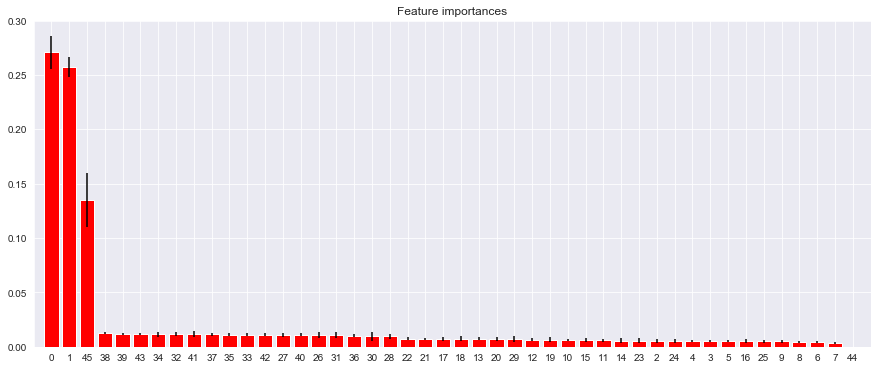

In [51]:
std = np.std([tree.feature_importances_ for tree in Forest_model_final.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_Train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15, 6))
plt.title("Feature importances")
plt.bar(range(X_Train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_Train.shape[1]), indices)
plt.xlim([-1, X_Train.shape[1]])
plt.show()

This shows that the most predictive models are:

1. Latitude
1. Longitude
1. Ward

The other features, particulraly the hour the crime took place, are less predictive.

In [16]:
Tree_model = DecisionTreeClassifier(criterion = "entropy", max_depth = 15).fit(X_Train, y_Train)

In [17]:
# Predict yhat using X_Test
yhat_dt = Forest_model_final.predict(X_Test)
    
# Measure the Jaccard Score of the final Model
jaccard_final = metrics.jaccard_similarity_score(y_Test, yhat_dt)
print('Jaccard Score', jaccard_final)
    
f1 = metrics.f1_score(y_Test, yhat_dt, average=None)
print('F1-Score of each class', f1)

Jaccard Score 0.6462361168243521
F1-Score of each class [0.60997732 0.67632668]
